### Data:
The dataset that will be used here is a publicly available data set of  the loans issued by the peer to peer online  lending platform called the Lending Club. The data was downloaded from the Kaggle website (https://www.kaggle.com/wendykan/lending-club-loan-data)

##  Preliminaries: Import Packages, Load Data and Familiarise
#### Import Packages 

In [5]:

import datetime as dt
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
sns.set(color_codes=True)
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics

#### Read and take a look at the data

In [6]:
loanbook=pd.read_csv('../rawdata/loan.csv', low_memory=False)


In [7]:
loanbook.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null object
sub_grade                      887379 non-null object
emp_title                      835917 non-null object
emp_length                     842554 non-null object
home_ownership                 887379 non-null object
annual_inc                     887375 non-null float64
verification_status            887379 non-null object
issue_d                        887379 non-null object
loan_status          

In [8]:
loanbook.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Output from loanbook.info() gives total no. of loans as 887379 and 74 columns


####  Distribution of Loan Amounts 

The column **loan_amnt** has as decribed in the data dictionary "The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value." So this gives us the amount of money that was borrowed. 

The column **issue_d** as described in the data dictionary is "The month which the loan was funded".

Grouping by date of issue and summing we can get the monthly loan totals which we will plot by year.


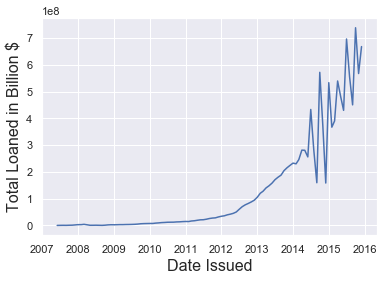

In [13]:
#convert issue_d to a datetime object.
loanbook['issue_d'] =  pd.to_datetime(loanbook['issue_d'], format='%b-%Y')

Amount=loanbook.groupby(by=['issue_d'])['loan_amnt'].sum()

plt.plot(Amount)
plt.xlabel('Month Issued', fontsize=16)
plt.ylabel('Total Loaned in Billion $', fontsize=16)
plt.show()


We see an increase in the total loans from 2007 to 2014. Slower increase from 2007 to 2011 and then taking off. It looks like surpassing a billion at the end of 2012.. this is corroborated in this article here.
https://www.bizjournals.com/sanfrancisco/print-edition/2012/11/09/lending-club-tops-1b-in-loans.html?page=all
Then we see those wide fluctuations from mid 2014 to 2016. That spikes my interest. Lets take a closer look.


Is it possible that some large but fewer loans were issued causing those peaks? Perhaps the total count of loans issued per year may shed light on this..

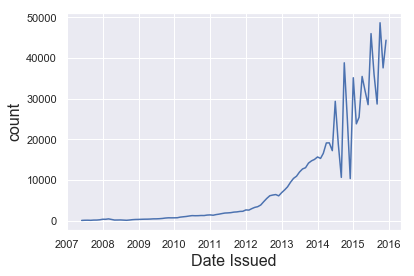

In [14]:
#take count of loans grouped by date(month) of issue.
count=loanbook.groupby(by=['issue_d'])['loan_amnt'].count()

plt.plot(count)
plt.xlabel('Month Issued', fontsize=16)
plt.ylabel('count', fontsize=16)
plt.show()

The total count of loans issued mirrors the total amount of loans. So those wide fluctuations are not caused by huge loans being issued but must be the result of an increase or decrease in the total number of loans issued. To confirm lets take a look at the distribution of the loan amounts by plotting a histogram.

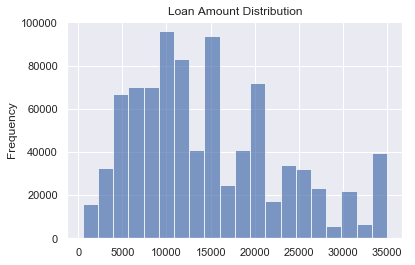

In [7]:
y= loanbook['loan_amnt']
pd.Series(y).plot(kind='hist',alpha=.7, bins=20, title='Loan Amount Distribution')

The histogram shows that the loans range from around **\$1000** to a max of **\$35000**. So it confirms that there are no huge loans that contribute to the fluctuations but instead there is an icrease and decrease of the total number of loans issued. Let's zoom in on the loan amounts by year to see if there are fluctuations in the earlier years as well. Because of the scale of plotting the fluctuations in the earlier years will not be as visible in the plot of total amounts vs year.  

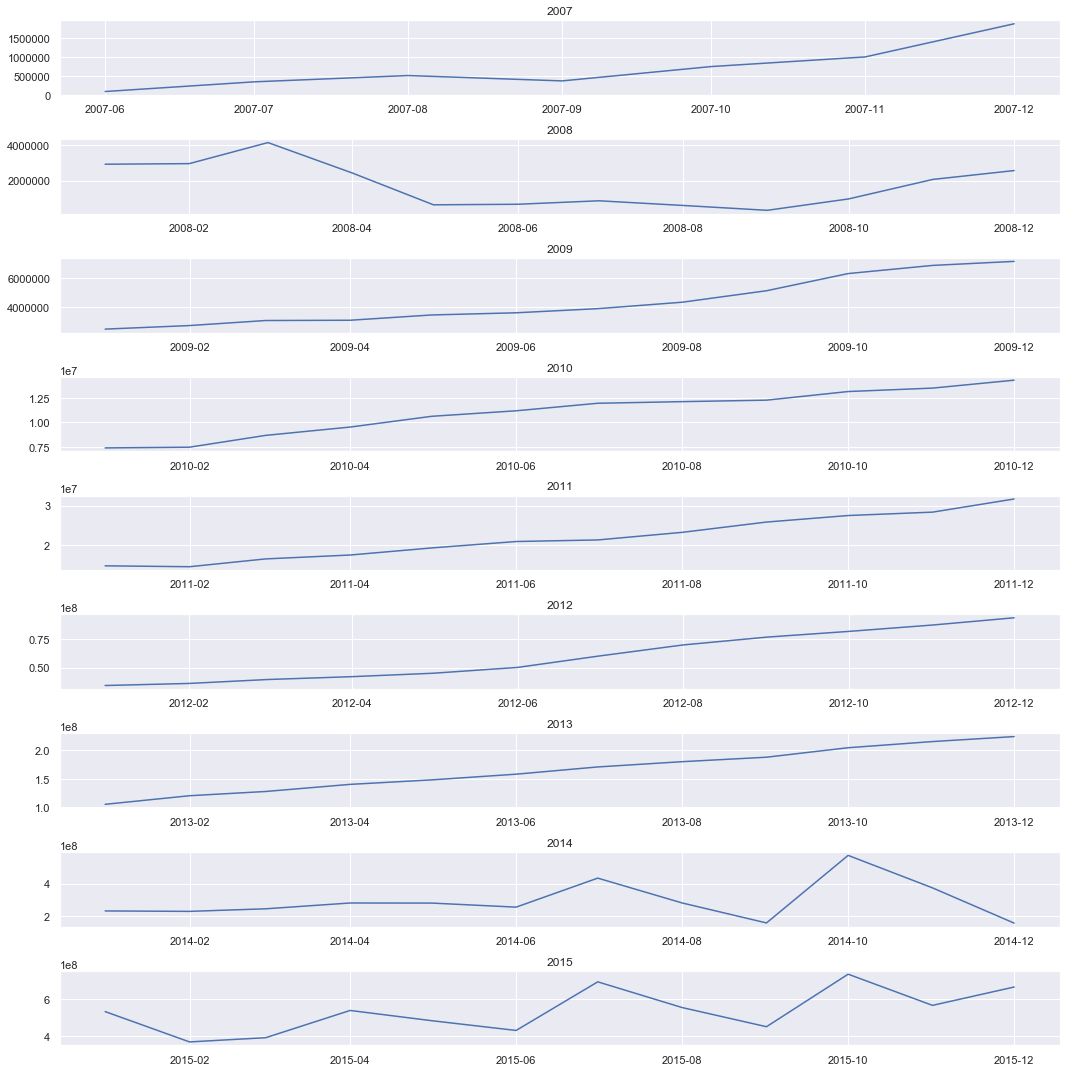

In [27]:
series_to_plot=['2007', '2008', '2009', "2010", "2011", "2012", "2013", "2014", "2015"]

fig, axes = plt.subplots(9,1 , figsize=(15,15))


for i, j in enumerate(series_to_plot):
    axes[i].plot(Amount[j])
    axes[i].set_title(j)
    fig.tight_layout() 
plt.show()

Looking at the total amounts closely we see that there is a steady increase in 2007 until February 2008, a sharp increase in March 2008 and then there is a sharp decline and the total loans issued remains at the same level until October 2008.  What could  be the reason for this? Doing a search " lending club history" reveals ..

From https://en.wikipedia.org/wiki/Lending_Club
On April 8, 2008, Lending Club temporarily suspended new lender registration, canceled its affiliate program and entered a "quiet period" while it awaited approval to issue promissory notes to lenders.[9] On June 20, 2008, Lending Club filed an S-1 statement[10] with the U.S. Securities and Exchange Commission (SEC) seeking the registration of $600 million in "Member Payment Dependent Notes" to be issued on its Web site.[11] On August 1, 2008, Lending Club filed an amendment to its Form S-1[12] outlining new interest rate formulas as well as more details on a "resale trading system".[13] On October 14, 2008, Lending Club announced its completion of the SEC registration process, posted the filed prospectus on its website, and resumed new lender registration.


Then we see a relatively steady increase in the total amount in loans issued until the fluctuations in 2014 - 2015. It is interesting to note that in the years 2014 and 2015 there are peaks in July and dips in September followed by peaks in October. 

From https://en.wikipedia.org/wiki/Lending_Club

In March 2014, Lending Club began providing loans to small businesses.[30] In April 2014 Lending Club acquired Springstone Financial.[31] In May 2014 Lending Club formed a partnership with Union Bank.[32] On August 27, 2014, Lending Club filed for an IPO with the SEC,[33] the offering taking place in December 2014.[34] 


###### .. and for 2015

From https://en.wikipedia.org/wiki/Lending_Club
Laplanche told Forbes in April 2015 that Lending Club would expand into car loans and mortgages.[36] Lending Club also announced a partnership with Google to extend credit to smaller companies that use Google's business services.[37] The company signed partnerships with Google, Alibaba.com, BancAlliance, and HomeAdvisor, including vetting community bank lenders for BancAlliance (a group of 200 banks), in order to send people on its platform to various community finance institutions.[38] That year Lending Club partnered with Opportunity Fund, announced by former President Bill Clinton at the Clinton Global Initiative. The partnership intended to provide $10 million to small businesses in areas of California that are underserved by lenders.[39] Lending Club and other small business lenders partnered with Sam’s Club to deliver its “business lending center” product.[40] In August 2015 the company created Lending Club Open Integration (LCOI).[41] In October, the company launched a multi-draw line of credit product for small businesses.[42]y

So it looks like these were two lucrative years with a lot of positive growth and expansion for lending club,
bringing in more customers and lenders.

This makes me wonder was there a change in the size of the loans? Perhaps there was an increase in the size of the loans issued? 

To look at this, plot histograms by year. We will also divide the loan amounts into the following bins,
0-1000, 1000-5000, 5-10,000, 10-15000, 15-20000, 20-25000, 25-40000. By using the option density =True 
we can look at how the loans change in proportion to the total number issued for the year.


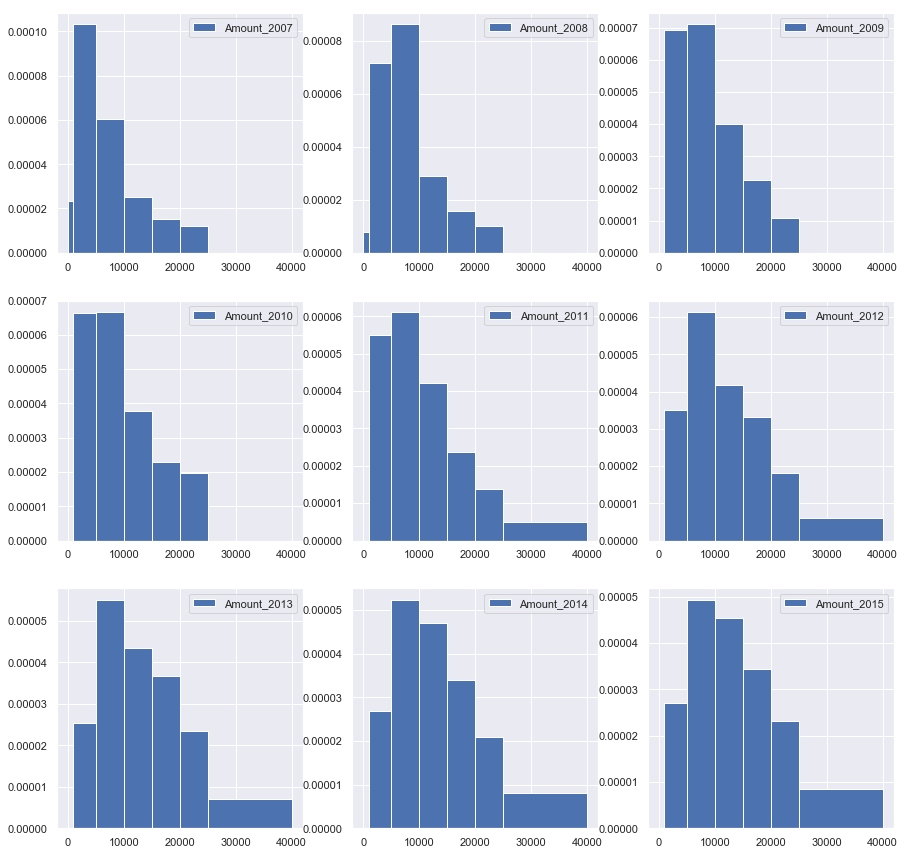

In [28]:

year= [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]

bins = [0, 1000, 5000.1, 10000.1, 15000.1, 20000.1, 25000.1, 40000.1]

dct= {}

for i in year:
      mask = (loanbook['issue_d'].dt.year == i)
      dct['Amount_%s' %i] = loanbook['loan_amnt'].loc[mask]   

f, axes = plt.subplots(3, 3, figsize=(15,15)) 
axes=axes.ravel()
for i, (key, value) in enumerate(dct.items()):

    axes[i].hist(value, label=key, bins=bins, density=True)
  
    axes[i].legend(loc="upper right")   

plt.legend()
plt.show()


There does appear to be a tendency for larger loans from 2010 onwards.
Upto 2010, the maximum loan amount issued was 25000 or below. From 2011 there was a proportion of loans in the 25000-40,000 range.